In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Launch Kaggle TPU session
print('Session Start!')

Session Start!


In [3]:
!pip install torch_geometric
!pip install indexed_bzip2
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 9.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 26.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_max_pool as gmp
import indexed_bzip2 as ibz2
import os
import pickle
import rdkit
from rdkit import Chem
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#from torch_scatter import scatter
from multiprocessing import Pool
from tqdm import tqdm
import gc
print('import DONE!')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


import DONE!


In [ ]:
#class GATNet(torch.nn.Module):
#    def __init__(self, num_features=9, n_output=3,n_filters=32, embed_dim=128, output_dim=1, dropout=0.5):
#        super(GATNet, self).__init__()

        # GATConv
#        self.gcn1 = GATConv(num_features, num_features , heads=10, dropout=dropout)
#        self.gcn2 = GATConv(num_features * 10, output_dim, dropout=dropout)
#        self.fc_g1 = nn.Linear(output_dim, output_dim)


 #       self.fc1 = nn.Linear(output_dim, 64)
 #       self.fc2 = nn.Linear(64, 32)
 #       self.out = nn.Linear(32, n_output)

        # relu and dropout
 #       self.relu = nn.ReLU()
 #       self.dropout = nn.Dropout(dropout)

 #   def forward(self, data):
 #       x, edge_index, batch = data.x.float(), data.edge_index, data.batch

 #      x = F.dropout(x, p=0.2, training=self.training)
 #       x = F.elu(self.gcn1(x, edge_index))
 #       x = F.dropout(x, p=0.2, training=self.training)
 #       x = self.gcn2(x, edge_index)
 #       x = self.relu(x)
 #       x = gmp(x, batch)          
 #       x = self.fc_g1(x)
 #       x = self.relu(x)#

        # dense layers
 #      xc = self.fc1(x)
 #       xc = self.relu(xc)
 #       xc = self.dropout(xc)
 #       xc = self.fc2(xc)
 #       xc = self.relu(xc)
 #       xc = self.dropout(xc)
 #       out = self.out(xc)
 #       return out
    
#model = GATNet()
#optimizer = optim.Adam(model.parameters(), lr=0.01)

#def custom_loss(output, target):
 #   loss = 0
 #   for i in range(3):  
 #       loss += F.binary_cross_entropy_with_logits(output[0][i], target[i].float())
 #   return loss / 3  


# Training
#def train_model(training_set):
  #  model.train()
 #   for data in training_set:
  #      optimizer.zero_grad()
 #       output = model(data)
        #print(output)
        #print(data.y)
        #print(output[0][2].float(), data.y[0].float())
  #      loss = custom_loss(output, data.y)#F.binary_cross_entropy_with_logits(output, data.y.view(-1, 3))
  #      loss.backward()
  #      optimizer.step()

In [5]:
#Load Train_graph
def load_compressed_ibz2_pickle(file):
    with ibz2.open(file, parallelization=os.cpu_count()) as f:
        data = pickle.load(f)
    return data
gdf_train = load_compressed_ibz2_pickle(
    '/kaggle/input/leash-bio-processed-dataset/train-replace-c-30m.graph.pickle.b2z'
)
print('train_graph Loaded!')
print(len(gdf_train))

# Load Train_bind
trainbind_data = np.load('/kaggle/input/leash-bio-processed-dataset/train.bind.npz')
train_bind = trainbind_data['bind']
trainbind_data.close()
print('train_bind Loaded!')
print(len(train_bind))

train_bind_30 = train_bind[:30000000]
print(len(gdf_train),len(train_bind_30))
print('DONE!')

train_graph Loaded!
30000000
train_bind Loaded!
98415610
30000000 30000000
DONE!


In [6]:
train_bind[:5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [7]:
zipped = list(zip(gdf_train,train_bind_30))

pos_class = [x for x in zipped if sum(x[1]) > 0]
neg_class = [x for x in zipped if sum(x[1]) == 0]
print(len(pos_class),len(neg_class))

822875 29177125


In [38]:
import random
random.shuffle(pos_class)
random.shuffle(neg_class)

train_sample = pos_class[:50000] + neg_class[:50000]
train_graph_sample = []
train_bind_sample = []
for i in train_sample:
    train_graph_sample.append(i[0])
    train_bind_sample.append(i[1])
    
test_sample = pos_class[50000:80000] + neg_class[50000:80000]
test_graph_sample = []
test_bind_sample = []
for i in test_sample:
    test_graph_sample.append(i[0])
    test_bind_sample.append(i[1])
    
print('length of train split: ',len(train_graph_sample), len(train_bind_sample))
print('length of test split: ',len(test_graph_sample), len(test_bind_sample))


length of train split:  100000 100000
length of test split:  60000 60000


In [9]:
train_bind_sample[-5:]

[array([0, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8)]

In [10]:
#Helper: convert graph to pyg list
def to_pyg_list(graph):
    L = len(graph)
    for i in tqdm(range(L)):
        N, edge, node_feature, edge_feature = graph[i]
        graph[i] = Data(
            idx=i,
            edge_index=torch.from_numpy(edge.T).int(),
            x=torch.from_numpy(node_feature).byte(),
            edge_attr=torch.from_numpy(edge_feature).byte(),
            y=torch.tensor(train_bind_sample[i])
        )
    return graph

#Helper for test_split
def to_pyg_list_test(graph):
    L = len(graph)
    for i in tqdm(range(L)):
        N, edge, node_feature, edge_feature = graph[i]
        graph[i] = Data(
            idx=i,
            edge_index=torch.from_numpy(edge.T).int(),
            x=torch.from_numpy(node_feature).byte(),
            edge_attr=torch.from_numpy(edge_feature).byte()
        )
    return graph

# Converted test_graph, with label
def to_pyg_list_tests_wlabel(graph):
    L = len(graph)
    for i in tqdm(range(L)):
        N, edge, node_feature, edge_feature = graph[i]
        graph[i] = Data(
            idx=i,
            edge_index=torch.from_numpy(edge.T).int(),
            x=torch.from_numpy(node_feature).byte(),
            edge_attr=torch.from_numpy(edge_feature).byte(),
            y=torch.tensor(test_bind_sample[i])
        )
    return graph
print('DONE!')

In [ ]:
pos_class[0]

In [12]:
# Converted train-graph, with label
train_graph = to_pyg_list(train_graph_sample)
test_graph_wlabel = to_pyg_list_tests_wlabel(test_graph_sample)
train_graph[:5]

100%|██████████| 100000/100000 [00:32<00:00, 3041.25it/s]


[Data(x=[43, 9], edge_index=[2, 90], edge_attr=[90, 1], y=[3], idx=0),
 Data(x=[40, 9], edge_index=[2, 88], edge_attr=[88, 1], y=[3], idx=1),
 Data(x=[42, 9], edge_index=[2, 92], edge_attr=[92, 1], y=[3], idx=2),
 Data(x=[43, 9], edge_index=[2, 94], edge_attr=[94, 1], y=[3], idx=3),
 Data(x=[52, 9], edge_index=[2, 110], edge_attr=[110, 1], y=[3], idx=4)]

In [14]:
class GATNet(torch.nn.Module):
    def __init__(self, num_features=9, n_output=3, output_dim=32, dropout=0.5):
        super(GATNet, self).__init__()

        self.gcn1 = GATConv(num_features, num_features, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features * 10, output_dim, dropout=dropout)
        self.fc_g1 = nn.Linear(output_dim, output_dim)

        # add batch normalization
        self.bn1 = nn.BatchNorm1d(output_dim)

        self.fc1 = nn.Linear(output_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, n_output)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x.float(), data.edge_index, data.batch

        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gcn2(x, edge_index)
        x = self.bn1(x)
        x = self.relu(x)
        x = gmp(x, batch)          
        x = self.fc_g1(x)
        x = self.relu(x)

        # Dense layers
        xc = self.fc1(x)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

model = GATNet()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

def custom_loss(output, target):
    output = output.view(-1)
    target = target.view(-1)
    return F.binary_cross_entropy_with_logits(output, target.float())

def train_model(training_set, batch_size=10000, epochs=20):
    model.train()
    dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            output = model(data)
            loss = custom_loss(output, data.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
            
        # update learning rate
        scheduler.step()  
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}')

In [15]:
# For Debug
training_set = train_graph#[:10000]#[Data(idx=-1, edge_index=None, x=torch.rand(5, 20), edge_attr=None, y=torch.tensor([0, 0, 1])) for _ in range(10)]

# Train with the training_set
train_model(training_set)
print('training DONE!')

Epoch 1, Loss: 0.696849650144577
Epoch 2, Loss: 0.6644028544425964
Epoch 3, Loss: 0.5936121881008148
Epoch 4, Loss: 0.4988322854042053
Epoch 5, Loss: 0.4686008870601654
Epoch 6, Loss: 0.4589704841375351
Epoch 7, Loss: 0.45583175122737885
Epoch 8, Loss: 0.452029624581337
Epoch 9, Loss: 0.4498435169458389
Epoch 10, Loss: 0.4489728808403015
Epoch 11, Loss: 0.4478583693504333
Epoch 12, Loss: 0.44720029830932617
Epoch 13, Loss: 0.44672539830207825
Epoch 14, Loss: 0.4463954508304596
Epoch 15, Loss: 0.4451391249895096
Epoch 16, Loss: 0.4458136647939682
Epoch 17, Loss: 0.44444332718849183
Epoch 18, Loss: 0.4447100579738617
Epoch 19, Loss: 0.4440837413072586
Epoch 20, Loss: 0.4437612771987915
training DONE!


In [16]:
# Prediction
def predict_label(data):
    model.eval()
    output = model(data)
    labels = torch.sigmoid(output).detach().numpy()
    #predicted_label = 0 if np.mean(labels)<0.1 else 1
    return labels#predicted_label

In [17]:
#to_pyg_list_test([test_graph_sample[0]])
test_graph_converted = to_pyg_list(test_graph_sample)

100%|██████████| 60000/60000 [00:11<00:00, 5140.86it/s] 


In [18]:
test_graph_converted[:5]

[Data(x=[42, 9], edge_index=[2, 90], edge_attr=[90, 1], y=[3], idx=0),
 Data(x=[35, 9], edge_index=[2, 76], edge_attr=[76, 1], y=[3], idx=1),
 Data(x=[36, 9], edge_index=[2, 76], edge_attr=[76, 1], y=[3], idx=2),
 Data(x=[43, 9], edge_index=[2, 92], edge_attr=[92, 1], y=[3], idx=3),
 Data(x=[40, 9], edge_index=[2, 86], edge_attr=[86, 1], y=[3], idx=4)]

In [19]:
len(test_graph_converted)

60000

In [20]:
# Prediction test
import random
for i in range(5):
    print(predict_label(test_graph_converted[i]))

[[0.2569119  0.21243864 0.40868405]]
[[0.2402421  0.19482583 0.3992709 ]]
[[0.26322466 0.21926193 0.4121846 ]]
[[0.2543393  0.20973235 0.40723255]]
[[0.2632865  0.2193036  0.41220307]]


In [ ]:
# Prediction test
import random
for i in range(5):
    print(predict_label(test_graph_converted[i]))

In [21]:
list(model.parameters())

[Parameter containing:
 tensor([[[ 0.0810,  0.0341,  0.4876,  0.2174,  0.3944,  0.0577, -0.0857,
           -0.1886, -0.2195],
          [-0.1136, -0.1659,  0.2240, -0.0566,  0.1951,  0.3224, -0.1357,
            0.0486, -0.0320],
          [-0.0276,  0.1990, -0.2819, -0.4354, -0.1501, -0.0008, -0.1713,
            0.2590, -0.0451],
          [-0.2639,  0.4170,  0.2838,  0.1842, -0.3190, -0.3012,  0.4477,
            0.2697, -0.3461],
          [-0.0300, -0.2134,  0.1605, -0.2549, -0.1952, -0.3475,  0.2108,
           -0.3644, -0.2165],
          [-0.0995, -0.2424,  0.3854, -0.3852,  0.2262,  0.0953,  0.3786,
           -0.4462,  0.2690],
          [-0.0365, -0.2370,  0.0455, -0.3768,  0.0512,  0.1824, -0.4564,
           -0.0362, -0.0697],
          [ 0.2706, -0.2849,  0.0481,  0.0414, -0.5032,  0.1024, -0.3281,
            0.0782,  0.3267],
          [ 0.0542, -0.3972, -0.4673, -0.0432,  0.3589, -0.1385, -0.4529,
            0.3830, -0.1765],
          [ 0.4028, -0.3172, -0.3102,  0.

In [ ]:
# Prediction test

#predict_label(to_pyg_list_test([test_graph_sample[1]])[0])

In [ ]:
#to_pyg_list_test([test_graph_sample[0]])

#test_graph_converted = to_pyg_list(test_graph_sample)

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(test_set, test_bind):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for i in range(5):#len(test_set):
            output = model(test_set[i])
            all_labels.append(test_bind[i])
            all_preds.append(output.sigmoid().numpy())
            
    #all_labels = np.concatenate(all_labels, axis=0)
    #all_preds = np.concatenate(all_preds, axis=0)
    
    return all_labels, all_preds
print((evaluate_model(test_graph_sample, test_bind_sample)[1][0]>= 0.5).astype(int))

[[0 0 0]]


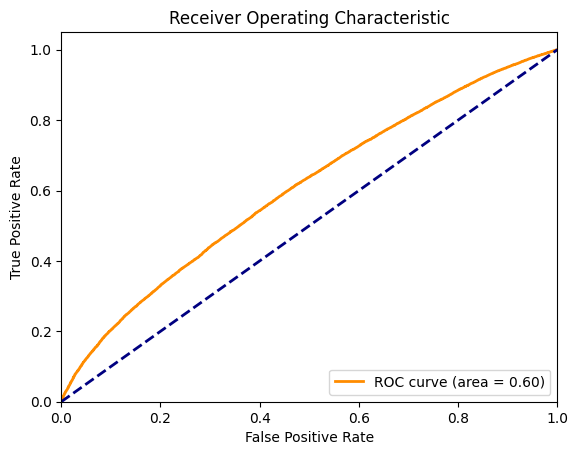

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool as gmp
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def evaluate_model(test_set):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for data in test_set:
            output = model(data)
            output_sigmoid = output.sigmoid().numpy()
            binary_labels = (np.sum(data.y.numpy()) > 0).astype(int)
            all_labels.extend([binary_labels])
            all_preds.extend(output_sigmoid.max(axis=1))  # Using max of three class, assuming positive correlation
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return all_labels, all_preds

lanels_, preds_ = evaluate_model(test_graph_wlabel)

In [53]:
len(preds_)
preds_[-5:]

array([0.41213965, 0.4073666 , 0.40619478, 0.4180869 , 0.40667605],
      dtype=float32)

threshold: 0.405, accuracy: 0.539
threshold: 0.4055, accuracy: 0.5415
threshold: 0.406, accuracy: 0.5437
threshold: 0.4065, accuracy: 0.5464
threshold: 0.407, accuracy: 0.549
threshold: 0.4075, accuracy: 0.5516
threshold: 0.408, accuracy: 0.5543
threshold: 0.4085, accuracy: 0.5572
threshold: 0.409, accuracy: 0.5601
threshold: 0.4095, accuracy: 0.5631
threshold: 0.41, accuracy: 0.5652
threshold: 0.4105, accuracy: 0.5669
threshold: 0.411, accuracy: 0.5681
threshold: 0.4115, accuracy: 0.5709
threshold: 0.412, accuracy: 0.5713
threshold: 0.4125, accuracy: 0.5715
threshold: 0.413, accuracy: 0.5708
threshold: 0.4135, accuracy: 0.5704
threshold: 0.414, accuracy: 0.5701
threshold: 0.4145, accuracy: 0.5674
DONE


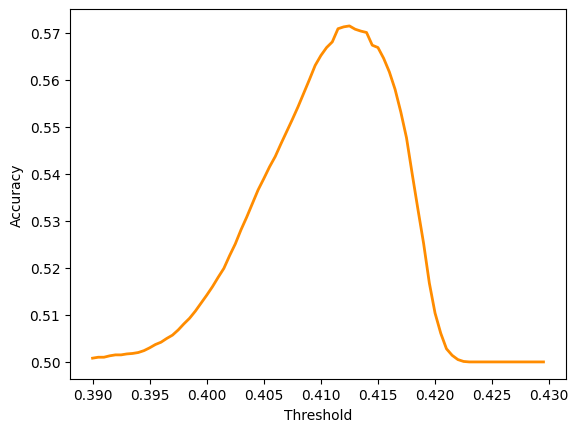

In [70]:
threshold = 0.39
stepsize = 0.0005
match_lst = []
threshold_lst = []
while threshold <=0.43:
    binary_pred_ = [1 if x >= threshold else 0 for x in preds_]
    match = np.round(np.mean([1 if x==y else 0 for x,y in zip(binary_pred_, lanels_)]),4)
    if 0.415>= threshold >= 0.405: 
        print(f'threshold: {np.round(threshold,4)}, accuracy: {match}')
    match_lst.append(match)
    threshold_lst.append(np.round(threshold,4))
    threshold += stepsize
print('DONE')

plt.figure()
plt.plot(threshold_lst, match_lst, color='darkorange', lw=2, label='acc')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Graph NN Code Repo

In [ ]:
import numpy as np

import rdkit
from rdkit import Chem

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter

import torch
import torch.nn as nn
import torch.nn.functional as F

print('import ok!')

In [ ]:
# helper
# torch version of np unpackbits
#https://gist.github.com/vadimkantorov/30ea6d278bc492abf6ad328c6965613a

def tensor_dim_slice(tensor, dim, dim_slice):
	return tensor[(dim if dim >= 0 else dim + tensor.dim()) * (slice(None),) + (dim_slice,)]

# @torch.jit.script
def packshape(shape, dim: int = -1, mask: int = 0b00000001, dtype=torch.uint8, pack=True):
	dim = dim if dim >= 0 else dim + len(shape)
	bits, nibble = (
		8 if dtype is torch.uint8 else 16 if dtype is torch.int16 else 32 if dtype is torch.int32 else 64 if dtype is torch.int64 else 0), (
		1 if mask == 0b00000001 else 2 if mask == 0b00000011 else 4 if mask == 0b00001111 else 8 if mask == 0b11111111 else 0)
	# bits = torch.iinfo(dtype).bits # does not JIT compile
	assert nibble <= bits and bits % nibble == 0
	nibbles = bits // nibble
	shape = (shape[:dim] + (int(math.ceil(shape[dim] / nibbles)),) + shape[1 + dim:]) if pack else (
				shape[:dim] + (shape[dim] * nibbles,) + shape[1 + dim:])
	return shape, nibbles, nibble

# @torch.jit.script
def F_unpackbits(tensor, dim: int = -1, mask: int = 0b00000001, shape=None, out=None, dtype=torch.uint8):
	dim = dim if dim >= 0 else dim + tensor.dim()
	shape_, nibbles, nibble = packshape(tensor.shape, dim=dim, mask=mask, dtype=tensor.dtype, pack=False)
	shape = shape if shape is not None else shape_
	out = out if out is not None else torch.empty(shape, device=tensor.device, dtype=dtype)
	assert out.shape == shape

	if shape[dim] % nibbles == 0:
		shift = torch.arange((nibbles - 1) * nibble, -1, -nibble, dtype=torch.uint8, device=tensor.device)
		shift = shift.view(nibbles, *((1,) * (tensor.dim() - dim - 1)))
		return torch.bitwise_and((tensor.unsqueeze(1 + dim) >> shift).view_as(out), mask, out=out)

	else:
		for i in range(nibbles):
			shift = nibble * i
			sliced_output = tensor_dim_slice(out, dim, slice(i, None, nibbles))
			sliced_input = tensor.narrow(dim, 0, sliced_output.shape[dim])
			torch.bitwise_and(sliced_input >> shift, mask, out=sliced_output)
	return out

class dotdict(dict):
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__
	
	def __getattr__(self, name):
		try:
			return self[name]
		except KeyError:
			raise AttributeError(name)

            
print('helper ok!')

In [ ]:
# mol to graph adopted from
# from https://github.com/LiZhang30/GPCNDTA/blob/main/utils/DrugGraph.py

PACK_NODE_DIM=9
PACK_EDGE_DIM=1
NODE_DIM=PACK_NODE_DIM*8
EDGE_DIM=PACK_EDGE_DIM*8

def one_of_k_encoding(x, allowable_set, allow_unk=False):
	if x not in allowable_set:
		if allow_unk:
			x = allowable_set[-1]
		else:
			raise Exception(f'input {x} not in allowable set{allowable_set}!!!')
	return list(map(lambda s: x == s, allowable_set))


#Get features of an atom (one-hot encoding:)
'''
	1.atom element: 44+1 dimensions    
	2.the atom's hybridization: 5 dimensions
	3.degree of atom: 6 dimensions                        
	4.total number of H bound to atom: 6 dimensions
	5.number of implicit H bound to atom: 6 dimensions    
	6.whether the atom is on ring: 1 dimension
	7.whether the atom is aromatic: 1 dimension           
	Total: 70 dimensions
'''

ATOM_SYMBOL = [
	'C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg',
	'Na', 'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl',
	'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H',
	'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
	'Pt', 'Hg', 'Pb', 'Dy',
	#'Unknown'
]
#print('ATOM_SYMBOL', len(ATOM_SYMBOL))44
HYBRIDIZATION_TYPE = [
	Chem.rdchem.HybridizationType.S,
	Chem.rdchem.HybridizationType.SP,
	Chem.rdchem.HybridizationType.SP2,
	Chem.rdchem.HybridizationType.SP3,
	Chem.rdchem.HybridizationType.SP3D
]

def get_atom_feature(atom):
	feature = (
		 one_of_k_encoding(atom.GetSymbol(), ATOM_SYMBOL)
	   + one_of_k_encoding(atom.GetHybridization(), HYBRIDIZATION_TYPE)
	   + one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
	   + one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5])
	   + one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
	   + [atom.IsInRing()]
	   + [atom.GetIsAromatic()]
	)
	#feature = np.array(feature, dtype=np.uint8)
	feature = np.packbits(feature)
	return feature


#Get features of an edge (one-hot encoding)
'''
	1.single/double/triple/aromatic: 4 dimensions       
	2.the atom's hybridization: 1 dimensions
	3.whether the bond is on ring: 1 dimension          
	Total: 6 dimensions
'''

def get_bond_feature(bond):
	bond_type = bond.GetBondType()
	feature = [
		bond_type == Chem.rdchem.BondType.SINGLE,
		bond_type == Chem.rdchem.BondType.DOUBLE,
		bond_type == Chem.rdchem.BondType.TRIPLE,
		bond_type == Chem.rdchem.BondType.AROMATIC,
		bond.GetIsConjugated(),
		bond.IsInRing()
	]
	#feature = np.array(feature, dtype=np.uint8)
	feature = np.packbits(feature)
	return feature


def smile_to_graph(smiles):
	mol = Chem.MolFromSmiles(smiles)
	N = mol.GetNumAtoms()
	node_feature = []
	edge_feature = []
	edge = []
	for i in range(mol.GetNumAtoms()):
		atom_i = mol.GetAtomWithIdx(i)
		atom_i_features = get_atom_feature(atom_i)
		node_feature.append(atom_i_features)

		for j in range(mol.GetNumAtoms()):
			bond_ij = mol.GetBondBetweenAtoms(i, j)
			if bond_ij is not None:
				edge.append([i, j])
				bond_features_ij = get_bond_feature(bond_ij)
				edge_feature.append(bond_features_ij)
	node_feature=np.stack(node_feature)
	edge_feature=np.stack(edge_feature)
	edge = np.array(edge,dtype=np.uint8)
	return N,edge,node_feature,edge_feature

def to_pyg_format(N,edge,node_feature,edge_feature):
	graph = Data(
		idx=-1,
		edge_index = torch.from_numpy(edge.T).int(),
		x          = torch.from_numpy(node_feature).byte(),
		edge_attr  = torch.from_numpy(edge_feature).byte(),
	)
	return graph

#debug one example
g = to_pyg_format(*smile_to_graph(smiles="C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1"))
print(g)
print('[Dy] is replaced by C !!')
print('smile_to_graph() ok!')

In [ ]:
print('DONE')

In [ ]:
import numpy as np

import rdkit
from rdkit import Chem

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter

import torch
import torch.nn as nn
import torch.nn.functional as F

print('import ok!')

In [ ]:
pip install rdkit

In [ ]:
DEVICE='cpu'

# i have removed all comments here to jepp it clean. refer to orginal link for code comments
# of MPNNModel
class MPNNLayer(MessagePassing):
	def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
		super().__init__(aggr=aggr)

		self.emb_dim = emb_dim
		self.edge_dim = edge_dim
		self.mlp_msg = nn.Sequential(
			nn.Linear(2 * emb_dim + edge_dim, emb_dim), nn.BatchNorm1d(emb_dim), nn.ReLU(),
			nn.Linear(emb_dim, emb_dim), nn.BatchNorm1d(emb_dim), nn.ReLU()
		)
		self.mlp_upd = nn.Sequential(
			nn.Linear(2 * emb_dim, emb_dim), nn.BatchNorm1d(emb_dim), nn.ReLU(),
			nn.Linear(emb_dim, emb_dim), nn.BatchNorm1d(emb_dim), nn.ReLU()
		)

	def forward(self, h, edge_index, edge_attr):
		out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
		return out

	def message(self, h_i, h_j, edge_attr):
		msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
		return self.mlp_msg(msg)

	def aggregate(self, inputs, index):
		return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

	def update(self, aggr_out, h):
		upd_out = torch.cat([h, aggr_out], dim=-1)
		return self.mlp_upd(upd_out)

	def __repr__(self) -> str:
		return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class MPNNModel(nn.Module):
    def __init__(self, num_layers=3, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        super().__init__()

        self.lin_in = nn.Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        self.pool = global_mean_pool

    def forward(self, data): #PyG.Data - batch of PyG graphs

        h = self.lin_in(F_unpackbits(data.x,-1).float())  

        for conv in self.convs:
            h = h + conv(h, data.edge_index.long(), F_unpackbits(data.edge_attr,-1).float())  # (n, d) -> (n, d)

        h_graph = self.pool(h, data.batch)  
        return h_graph

# our prediction model here !!!!
class Net(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.output_type = ['infer', 'loss']

        graph_dim=96
        self.smile_encoder = MPNNModel(
            in_dim=NODE_DIM, edge_dim=EDGE_DIM, emb_dim=graph_dim, num_layers=4,
        )
        self.bind = nn.Sequential(
            nn.Linear(graph_dim, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 3),
        )

    def forward(self, batch):
        graph = batch['graph']
        x = self.smile_encoder(graph) 
        bind = self.bind(x)

        # --------------------------
        output = {}
        if 'loss' in self.output_type:
            target = batch['bind']
            output['bce_loss'] = F.binary_cross_entropy_with_logits(bind.float(), target.float())
        if 'infer' in self.output_type:
            output['bind'] = torch.sigmoid(bind)

        return output
    
print('Create Model OK!')

In [ ]:
#debug: make some dummy data and run

def run_check_net():
	batch_size = 3
	node_dim=NODE_DIM
	edge_dim=EDGE_DIM

	data = []
	for b in range(batch_size):
		N = np.random.randint(5,10)
		E = np.random.randint(3,N*(N-1))
		edge_index = np.stack([
			np.random.choice(N, E, replace=True),
			np.random.choice(N, E, replace=True),
		]).T
		edge_index = np.sort(edge_index)
		edge_index = edge_index[edge_index[:, 0].argsort()]
		edge_index[0] = [0,1] #default
		edge_index = edge_index[edge_index[:,0]!=edge_index[:,1]]
		edge_index = np.unique(edge_index, axis=0)

		E = len(edge_index)
		edge_index = np.ascontiguousarray(edge_index.T)

		d = Data(
			idx        = b,
			edge_index = torch.from_numpy(edge_index).int(),
			x          = torch.from_numpy(np.packbits(np.random.choice(2, (N, node_dim)),-1)).byte(),
			edge_attr  = torch.from_numpy(np.packbits(np.random.choice(2, (E, edge_dim)),-1)).byte(),
		)
		data.append(d)

	#from my_mol2graph import make_dummy_data
	#data = make_dummy_data()

	loader = DataLoader(data, batch_size=batch_size)
	graph = next(iter(loader))
	idx = graph.idx.tolist()  #use to index bind array
	batch = dotdict( 
		graph = graph.to(DEVICE),
		bind  = torch.from_numpy(np.random.choice(2, (batch_size, 3))).float().to(DEVICE),
	)
	zz=0
 
	net = Net().to(DEVICE)
	#print(net)

	with torch.no_grad():
		with torch.cuda.amp.autocast(enabled=True): # dtype=torch.float16):
			output = net(batch)
			#print(output['bind'])

	# ---
	print('batch')
	for k, v in batch.items():
		if k=='idx':
			print(f'{k:>32} : {len(v)} ')
		elif k=='graph':
			print(f'{k:>32} : {graph} ')
		else:
			print(f'{k:>32} : {v.shape} ')

	print('output')
	for k, v in output.items():
		if 'loss' not in k:
			print(f'{k:>32} : {v.shape} ')
	print('loss')
	for k, v in output.items():
		if 'loss' in k:
			print(f'{k:>32} : {v.item()} ')

            
run_check_net()
print('model ok!')

In [ ]:
def my_collate(graph, index=None, device='cpu'):
    if index is None:
        index = np.arange(len(graph)).tolist()
    batch = dotdict(
        x=[],
        edge_index=[],
        edge_attr=[],
        batch=[],
        idx=index
    )
    offset = 0
    for b, i in enumerate(index):
        N, edge, node_feature, edge_feature = graph[i]
        batch.x.append(node_feature)
        batch.edge_attr.append(edge_feature)
        batch.edge_index.append(edge.astype(int) + offset)
        batch.batch += N * [b]
        offset += N
    batch.x = torch.from_numpy(np.concatenate(batch.x)).to(device)
    batch.edge_attr = torch.from_numpy(np.concatenate(batch.edge_attr)).to(device)
    batch.edge_index = torch.from_numpy(np.concatenate(batch.edge_index).T).to(device)
    batch.batch = torch.LongTensor(batch.batch).to(device)
    return batch


#.... more code here ....

while epoch<cfg.num_epoch:
    shuffled_idx = train_idx.copy()
    np.random.shuffle(shuffled_idx)
    for t, index in enumerate(np.arange(0,len(shuffled_idx),cfg.train_batch_size)):
        index = shuffled_idx[index:index+cfg.train_batch_size]
        if len(index)!=cfg.train_batch_size: continue #drop last

        B = len(index)
        batch = dotdict(
            graph = my_collate(train_graph,index,device='cuda'),
            bind = torch.from_numpy(train_bind[index]).float().cuda(),
        )

        net.train()
        net.output_type = ['loss', 'infer']

        with torch.cuda.amp.autocast(enabled=cfg.is_amp):
            output = net(batch)  #data_parallel(net,batch) #
            bce_loss = output['bce_loss']

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm
import gc
from torch_geometric.loader import DataLoader as PyGDataLoader

def to_pyg_list(graph):
	L = len(graph)
	for i in tqdm(range(L)):
		N, edge, node_feature, edge_feature = graph[i]
		graph[i] = Data(
			idx=i,
			edge_index=torch.from_numpy(edge.T).int(),
			x=torch.from_numpy(node_feature).byte(),
			edge_attr=torch.from_numpy(edge_feature).byte(),
		)
	return graph


train_smiles=[ #replace [Dy] with C
    "C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1",
    "C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1",
    "C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1",
    "C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1",
    "C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1",
    "C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC#C)CC(=O)NC)n2)cc1",
]
train_bind =np.array([
    [0,0,0],[1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,0,0],
])
num_train= len(train_smiles)
with Pool(processes=64) as pool:
    train_graph = list(tqdm(pool.imap(smile_to_graph, train_smiles), total=num_train))

train_graph = to_pyg_list(train_graph)
train_loader = PyGDataLoader(train_graph, batch_size=3, shuffle=True)



In [ ]:
## example training loop
scaler = torch.cuda.amp.GradScaler(enabled=True)
net = Net()
net.to(DEVICE)

optimizer =\
	torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

num_epoch=10
epoch=0
iteration=0
while epoch<num_epoch: 
	for t, graph_batch in enumerate(train_loader): 
		index = graph_batch.idx.tolist()
		B = len(index)
		batch = dotdict(
			graph  = graph_batch.to(DEVICE),
			bind   = torch.from_numpy(train_bind[index]).to(DEVICE),
		)

		net.train()
		net.output_type = ['loss', 'infer']
		with torch.cuda.amp.autocast(enabled=True):
			output = net(batch)  #data_parallel(net,batch) #
			bce_loss = output['bce_loss']

		optimizer.zero_grad() 
		scaler.scale(bce_loss).backward() 
		scaler.step(optimizer)
		scaler.update()
		 
		torch.clear_autocast_cache()
		print(epoch,iteration,bce_loss.item())
		iteration +=  1
        
	epoch += 1

In [ ]:
train_path ='/kaggle/input/leash-BELKA/train.parquet'

con = duckdb.connect()
df_train = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 30000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 30000)""").df()
con.close()
print('DONE!')

In [ ]:
df_train.head()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_max_pool as gmp

# GAT  model
class GATNet(torch.nn.Module):
    def __init__(self, num_features=112, n_output=1,n_filters=32, embed_dim=128, output_dim=128, dropout=0.2):
        super(GATNet, self).__init__()

        # graph layers
        self.gcn1 = GATConv(num_features, num_features, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features * 10, output_dim, dropout=dropout)
        self.fc_g1 = nn.Linear(output_dim, output_dim)

        # combined layers
        self.fc1 = nn.Linear(output_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, n_output)

        # activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        # graph input feed-forward
        x, edge_index, batch = data.x.float(), data.edge_index, data.batch

        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gcn2(x, edge_index)
        x = self.relu(x)
        x = gmp(x, batch)          # global max pooling
        x = self.fc_g1(x)
        x = self.relu(x)

       
        # add some dense layers
        xc = self.fc1(x)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out